#Introduction

In this guide, I will demonstrate how to build a Retrieval-Augmented Generation (RAG) system using LangChain, FAISS, and Hugging Face's Transformers library. The goal is to process and query the contents of a PDF document effectively. This approach combines document retrieval with a question-answering model to provide precise answers from a given document.

## Install Necessary Packages

In [1]:
%pip install sentence-transformers faiss-cpu langchain PyPDF2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.9 MB/s eta 0:00:00


## Load and Process the PDF:
We'll use PyPDF2 to read the PDF and LangChain to process it:

In [3]:
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

def load_pdf(file_path):
    with open(file_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

# Load your PDF file
pdf_text = load_pdf("/content/Deep Learning Notes Andrew Ng.pdf")

# Split the text into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_text(pdf_text)

# Create document objects from chunks
documents = [Document(page_content=chunk) for chunk in chunks]

In [6]:
documents[10]

Document(page_content='the second layer family size (or instead, the \x0crst node of the \x0crst layer), the second\nnode, and the third node. The third layer will give us a price.\nThere are supervised learning and unsupervised learning. For supervised learning,\nwe have a given output (y). Such applications have successful results in real estate, on-\nline, advertising, photo tagging, speech recognition, machine translation, autonomous\ndriving. The goal would just to be trying to \x0ct neural networks to these data sets. In\nreal estate, it is standard neural networks that work out well. For photo tagging, it\nis CNN that works well. For sequence data such as speech recognition and language\ntranslation, RNN and improved RNN work out well. Autonomous would work better\nwith CNN or custom CNN (hybrid CNN).\nThere could also be the di\x0berence of structured and unstructured data. For data set\nsuch as predicting housing price given size, # of bedrooms, etc. variables, these data')

## Implement the RAG Pipeline:

In [8]:
! pip install -U langchain-community --quiet
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00


In [9]:
from sentence_transformers import SentenceTransformer
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from transformers import pipeline

In [10]:
# Initialize the SentenceTransformer model for embeddings
embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Create the FAISS index for document retrieval
vectorstore = FAISS.from_documents(documents, embedding_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Embedding Visualization

In [11]:
from langchain.vectorstores import FAISS
import numpy as np

# Assume 'vectorstore' is your FAISS vector store instance

# Access the underlying FAISS index
faiss_index = vectorstore.index

# Number of embeddings stored
num_embeddings = faiss_index.ntotal

# Retrieve the stored embeddings
embeddings = faiss_index.reconstruct_n(0, num_embeddings)

print(f"Number of embeddings: {num_embeddings}")
print(f"Embeddings shape: {embeddings.shape}")
print("First 5 embeddings:")
print(embeddings[:5])

Number of embeddings: 155
Embeddings shape: (155, 384)
First 5 embeddings:
[[-0.16353649 -0.06192001  0.08279113 ...  0.01406404 -0.15224083
  -0.01307885]
 [-0.04410101 -0.05776671 -0.0245056  ...  0.00603817 -0.00367147
  -0.01786388]
 [-0.04323677 -0.0265846  -0.04196526 ...  0.04058856  0.01150676
  -0.05300631]
 [-0.01238079 -0.00832261 -0.06357092 ... -0.01162716 -0.09147093
  -0.02771159]
 [-0.01396316 -0.06434277  0.01278549 ...  0.02772076 -0.00707363
  -0.00436012]]


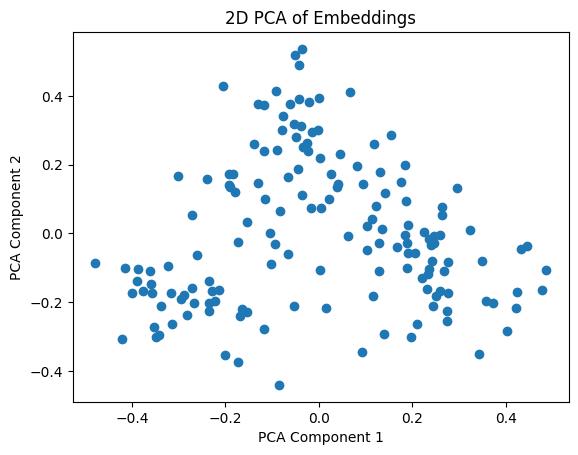

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('2D PCA of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

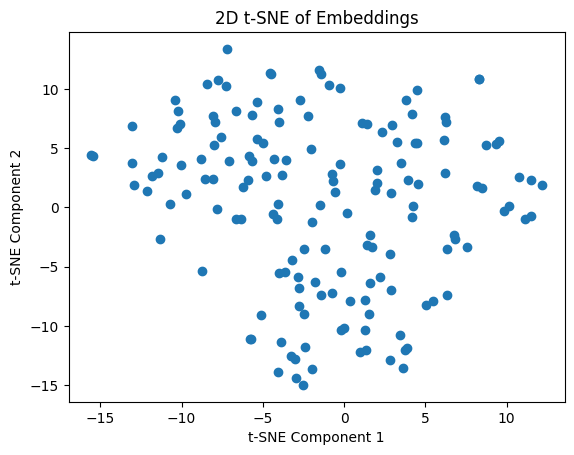

In [13]:
from sklearn.manifold import TSNE

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('2D t-SNE of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [20]:
# Accessing index details
print(f"Number of vectors (embeddings) in the index: {faiss_index.ntotal}")
print(f"Dimensionality of the vectors: {faiss_index.d}")

Number of vectors (embeddings) in the index: 155
Dimensionality of the vectors: 384


In [16]:
# Initialize the Hugging Face pipeline for question-answering
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# Function to ask questions
def ask_question(query):
    # Retrieve documents
    retrieved_docs = vectorstore.as_retriever().get_relevant_documents(query)
    # Concatenate the retrieved documents into a single context
    context = " ".join([doc.page_content for doc in retrieved_docs])
    # Perform the QA task using the context and question
    result = qa_pipeline(question=query, context=context)
    return result['answer']

In [17]:
# Example question
question = "What wrote Deep Learning Notes?"
answer = ask_question(question)
print("Answer:", answer)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Answer: Yiqiao Yin


In [18]:
# Example question
question = "What is Relu?"
answer = ask_question(question)
print("Answer:", answer)

Answer: as activation functions


In [19]:
# Example question
question = "What is Instructor?"
answer = ask_question(question)
print("Answer:", answer)

Answer: Andrew Ng


# Summary
This implementation reads a PDF, splits it into chunks, indexes the chunks using FAISS, and sets up a Retrieval-Augmented Generation (RAG) pipeline with LangChain. You can then ask questions about the PDF content, and the system will retrieve relevant chunks and generate answers.